# Evolução do Banco de Dados - PostgreSQL/MySQL


## Objetivos:
- **Etapa 1**: Configurar conexão com PostgreSQL ou MySQL
- **Etapa 2**: Criar schema do banco de dados em SQL
- Implementar estrutura de tabelas dimensionais e fatos
- Criar índices e constraints para otimização


## Etapa 1: Configuração do Banco de Dados

Nesta etapa, vamos configurar a conexão com o banco de dados.

### Opções disponíveis:
- **PostgreSQL** (recomendado para análises e data warehouse)
- **MySQL** (alternativa popular)

### Instalação das bibliotecas necessárias:
```bash

In [ ]:
pip install pandas mysql-connector-python sqlalchemy psycopg2-binary

In [ ]:
# Importar bibliotecas necessárias
import pandas as pd
from sqlalchemy import create_engine, text
import warnings
warnings.filterwarnings('ignore')

print("✓ Bibliotecas importadas com sucesso")

✓ Bibliotecas importadas com sucesso


### Configuração de Conexão

**Escolha uma das opções abaixo:**

#### Opção 1: PostgreSQL (Recomendado)
```python
# Configurações PostgreSQL
DB_TYPE = 'postgresql'
DB_USER = 'seu_usuario'
DB_PASSWORD = 'sua_senha'
DB_HOST = 'localhost'
DB_PORT = '5432'
DB_NAME = 'ecommerce_dw'
```

#### Opção 2: MySQL
```python
# Configurações MySQL
DB_TYPE = 'mysql'
DB_USER = 'seu_usuario'
DB_PASSWORD = 'sua_senha'
DB_HOST = 'localhost'
DB_PORT = '3306'
DB_NAME = 'ecommerce_dw'
```

In [ ]:
# ==========================================
#     CONFIGURAÇÃO DA CONEXÃO
# ==========================================

# Escolha o tipo de banco de dados: 'postgresql' ou 'mysql'
DB_TYPE = 'postgresql'  # Altere para 'mysql' se preferir

# Configurações de conexão
DB_USER = 'postgres'      # Usuário do banco
DB_PASSWORD = 'postgres'  # Senha do banco
DB_HOST = 'localhost'     # Host (localhost ou IP do servidor)
DB_PORT = '5432'          # Porta (5432 para PostgreSQL, 3306 para MySQL)
DB_NAME = 'ecommerce_dw'  # Nome do banco de dados

# Criar string de conexão
if DB_TYPE == 'postgresql':
    connection_string = f'postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}'
    driver = 'psycopg2'
elif DB_TYPE == 'mysql':
    connection_string = f'mysql+mysqlconnector://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}'
    driver = 'mysql-connector-python'
else:
    raise ValueError("DB_TYPE deve ser 'postgresql' ou 'mysql'")

print(f"✓ Configuração definida para: {DB_TYPE.upper()}")
print(f"✓ String de conexão: {connection_string.replace(DB_PASSWORD, '***')}")

✓ Configuração definida para: POSTGRESQL
✓ String de conexão: ***ql://***:***@localhost:5432/ecommerce_dw


In [ ]:
# ==========================================
#     TESTAR CONEXÃO COM O BANCO
# ==========================================

try:
    # Criar engine de conexão
    engine = create_engine(connection_string)
    
    # Testar conexão
    with engine.connect() as conn:
        result = conn.execute(text("SELECT 1"))
        print("✓ Conexão estabelecida com sucesso!")
        print(f"✓ Banco de dados: {DB_NAME}")
        print(f"✓ Tipo: {DB_TYPE.upper()}")
        
except Exception as e:
    print(f"✗ Erro ao conectar ao banco de dados:")
    print(f"  {str(e)}")
    print("\n💡 Dicas:")
    print("  1. Verifique se o servidor do banco está rodando")
    print("  2. Confirme usuário e senha")
    print("  3. Certifique-se que o banco de dados existe")
    if DB_TYPE == 'postgresql':
        print("  4. Para PostgreSQL, crie o banco com: CREATE DATABASE ecommerce_dw;")
    else:
        print("  4. Para MySQL, crie o banco com: CREATE DATABASE ecommerce_dw;")

---

## Etapa 2: Criar Schema do Banco de Dados

Nesta etapa, vamos criar a estrutura completa do Data Warehouse em SQL, incluindo:

- **Tabelas Dimensionais** (dim_country, dim_customer, dim_date, dim_product)
- **Tabela Fato** (fact_sales)
- **Tabela de Métricas** (metrics)
- **Índices** para otimização de consultas
- **Constraints** (chaves primárias e estrangeiras)

### Modelo Dimensional (Star Schema)

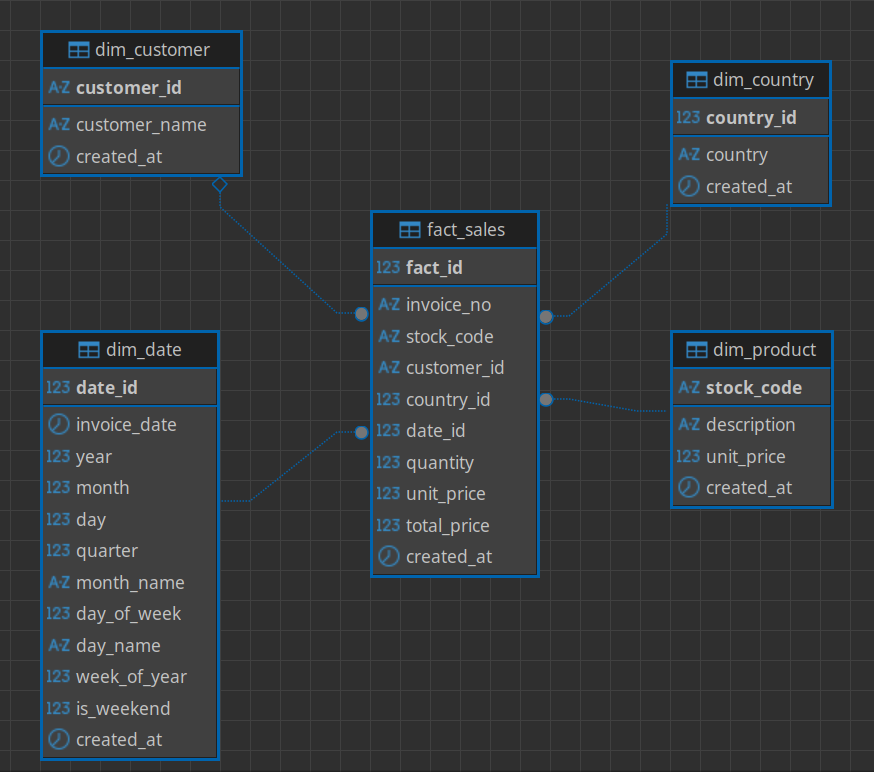

### 2.1 Script SQL - Tabelas Dimensionais

In [ ]:
# ==========================================
#     SQL: CRIAR TABELAS DIMENSIONAIS
# ==========================================

sql_create_dimensions = """
DROP TABLE IF EXISTS dim_country;
CREATE TABLE dim_country (
    country_id INT AUTO_INCREMENT PRIMARY KEY,
    country VARCHAR(100) NOT NULL UNIQUE,
    created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
);

DROP TABLE IF EXISTS dim_customer;
CREATE TABLE dim_customer (
    customer_id VARCHAR(50) PRIMARY KEY,
    customer_name VARCHAR(255),
    created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
);

DROP TABLE IF EXISTS dim_date;
CREATE TABLE dim_date (
    date_id INT AUTO_INCREMENT PRIMARY KEY,
    invoice_date DATE NOT NULL UNIQUE,
    year INT NOT NULL,
    month INT NOT NULL,
    day INT NOT NULL,
    quarter INT NOT NULL,
    month_name VARCHAR(20),
    day_of_week INT,
    day_name VARCHAR(20),
    week_of_year INT,
    is_weekend BOOLEAN,
    created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
);

DROP TABLE IF EXISTS dim_product;
CREATE TABLE dim_product (
    stock_code VARCHAR(50) PRIMARY KEY,
    description VARCHAR(500),
    unit_price DECIMAL(10, 2),
    created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
);
"""

print("✓ Script SQL de criação das dimensões preparado")
print(f"✓ Total de linhas SQL: {len(sql_create_dimensions.split(chr(10)))}")

### 2.2 Script SQL - Tabela Fato

In [ ]:
# ==========================================
#     SQL: CRIAR TABELA FATO
# ==========================================

sql_create_fact = """
DROP TABLE IF EXISTS fact_sales;
CREATE TABLE fact_sales (
    fact_id INT AUTO_INCREMENT PRIMARY KEY,
    invoice_no VARCHAR(50) NOT NULL,
    stock_code VARCHAR(50) NOT NULL,
    customer_id VARCHAR(50),
    country_id INT NOT NULL,
    date_id INT NOT NULL,
    quantity INT NOT NULL,
    unit_price DECIMAL(10, 2) NOT NULL,
    total_price DECIMAL(12, 2) NOT NULL,
    created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
    CONSTRAINT fk_product FOREIGN KEY (stock_code) REFERENCES dim_product(stock_code) ON DELETE CASCADE,
    CONSTRAINT fk_customer FOREIGN KEY (customer_id) REFERENCES dim_customer(customer_id) ON DELETE SET NULL,
    CONSTRAINT fk_country FOREIGN KEY (country_id) REFERENCES dim_country(country_id) ON DELETE CASCADE,
    CONSTRAINT fk_date FOREIGN KEY (date_id) REFERENCES dim_date(date_id) ON DELETE CASCADE
);

CREATE INDEX idx_fact_invoice ON fact_sales(invoice_no);
CREATE INDEX idx_fact_stock_code ON fact_sales(stock_code);
CREATE INDEX idx_fact_customer ON fact_sales(customer_id);
CREATE INDEX idx_fact_country ON fact_sales(country_id);
CREATE INDEX idx_fact_date ON fact_sales(date_id);
CREATE INDEX idx_fact_total_price ON fact_sales(total_price);
CREATE INDEX idx_fact_invoice_date ON fact_sales(invoice_no, date_id);
"""

print("✓ Script SQL de criação da tabela fato preparado")
print(f"✓ Total de linhas SQL: {len(sql_create_fact.split(chr(10)))}")

### 2.3 Script SQL - Tabela de Métricas

In [ ]:
# ==========================================
#     SQL: CRIAR TABELA DE MÉTRICAS
# ==========================================

sql_create_metrics = """
DROP TABLE IF EXISTS metrics;
CREATE TABLE metrics (
    metric_id INT AUTO_INCREMENT PRIMARY KEY,
    country VARCHAR(100) NOT NULL,
    total_revenue DECIMAL(15, 2),
    total_quantity INT,
    total_invoices INT,
    total_customers INT,
    total_products INT,
    avg_ticket DECIMAL(12, 2),
    avg_quantity_per_invoice DECIMAL(10, 2),
    calculated_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
    CONSTRAINT unique_country_metrics UNIQUE (country)
);

CREATE INDEX idx_metrics_country ON metrics(country);
CREATE INDEX idx_metrics_revenue ON metrics(total_revenue);
"""

print("✓ Script SQL de criação da tabela de métricas preparado")
print(f"✓ Total de linhas SQL: {len(sql_create_metrics.split(chr(10)))}")

### 2.4 Executar Scripts SQL - Criar Schema Completo

In [ ]:
# ==========================================
#     EXECUTAR SCRIPTS SQL
# ==========================================

try:
    with engine.connect() as conn:
        print("Executando criação das tabelas dimensionais...")
        conn.execute(text(sql_create_dimensions))
        conn.commit()
        print("✓ Tabelas dimensionais criadas com sucesso!")
        
        print("\nExecutando criação da tabela fato...")
        conn.execute(text(sql_create_fact))
        conn.commit()
        print("✓ Tabela fato criada com sucesso!")
        
        print("\nExecutando criação da tabela de métricas...")
        conn.execute(text(sql_create_metrics))
        conn.commit()
        print("✓ Tabela de métricas criada com sucesso!")
        
        print("\n" + "="*60)
        print("✓✓✓ SCHEMA DO BANCO DE DADOS CRIADO COM SUCESSO! ✓✓✓")
        print("="*60)
        
except Exception as e:
    print(f"✗ Erro ao criar schema:")
    print(f"  {str(e)}")

### 2.5 Verificar Tabelas Criadas

In [ ]:
# ==========================================
#     VERIFICAR TABELAS CRIADAS
# ==========================================

# SQL para listar tabelas (compatível com PostgreSQL e MySQL)
if DB_TYPE == 'postgresql':
    sql_list_tables = """
    SELECT table_name, table_type
    FROM information_schema.tables
    WHERE table_schema = 'public'
    ORDER BY table_name;
    """
else:  # MySQL
    sql_list_tables = f"""
    SELECT table_name, table_type
    FROM information_schema.tables
    WHERE table_schema = '{DB_NAME}'
    ORDER BY table_name;
    """

try:
    with engine.connect() as conn:
        result = pd.read_sql(sql_list_tables, conn)
        
        print("TABELAS CRIADAS NO BANCO DE DADOS:")
        print("="*60)
        print(result.to_string(index=False))
        print("="*60)
        print(f"\n✓ Total de tabelas: {len(result)}")
        
        # Verificar se todas as tabelas esperadas foram criadas
        expected_tables = ['dim_country', 'dim_customer', 'dim_date', 'dim_product', 
                          'fact_sales', 'metrics']
        created_tables = result['table_name'].tolist()
        
        print("\nVERIFICAÇÃO DAS TABELAS:")
        for table in expected_tables:
            status = "✓" if table in created_tables else "✗"
            print(f"  {status} {table}")
            
except Exception as e:
    print(f"✗ Erro ao listar tabelas:")
    print(f"  {str(e)}")

### 2.6 Visualizar Estrutura das Tabelas

In [ ]:
# ==========================================
#     VISUALIZAR ESTRUTURA DAS TABELAS
# ==========================================

def describe_table(table_name):
    """Função para descrever a estrutura de uma tabela"""
    
    if DB_TYPE == 'postgresql':
        sql_describe = f"""
        SELECT 
            column_name,
            data_type,
            character_maximum_length,
            is_nullable,
            column_default
        FROM information_schema.columns
        WHERE table_name = '{table_name}'
        ORDER BY ordinal_position;
        """
    else:  # MySQL
        sql_describe = f"DESCRIBE {table_name};"
    
    try:
        with engine.connect() as conn:
            result = pd.read_sql(sql_describe, conn)
            print(f"\nEstrutura da tabela: {table_name.upper()}")
            print("="*80)
            print(result.to_string(index=False))
            print("="*80)
    except Exception as e:
        print(f"✗ Erro ao descrever tabela {table_name}: {str(e)}")

# Descrever todas as tabelas
tables_to_describe = ['dim_country', 'dim_customer', 'dim_date', 'dim_product', 
                      'fact_sales', 'metrics']

for table in tables_to_describe:
    describe_table(table)

---

## Resumo da Evolução do Banco de Dados

### ✓ Etapa 1 Concluída: Configuração
- Conexão com PostgreSQL/MySQL estabelecida
- Engine SQLAlchemy configurada
- Teste de conexão realizado

### ✓ Etapa 2 Concluída: Schema SQL
- **5 Tabelas Dimensionais**: dim_country, dim_customer, dim_date, dim_product
- **1 Tabela Fato**: fact_sales
- **1 Tabela de Métricas**: metrics
- **Constraints**: Chaves primárias e estrangeiras
- **Índices**: Otimização de consultas
